$\textbf{Voltage and Bowl Calibration}$

$\text{After the cropping the dataset we can do the voltage and bowl correction to clibrate the data.}$

In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from IPython.display import display

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools



In [2]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [3]:
tdc, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

In [4]:
tdc_model = tdc.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/vol_bowl_calibratin/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_startCounter = data['dld/start_counter'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [ ]:
data

In [4]:
# t0
dld_t = dld_t - t0

In [5]:
# Remove negative and zero TOF
threshold = 60
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_pulseVoltage = dld_pulseVoltage[dld_t>threshold]
dld_startCounter = dld_startCounter[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

<IPython.core.display.Javascript object>


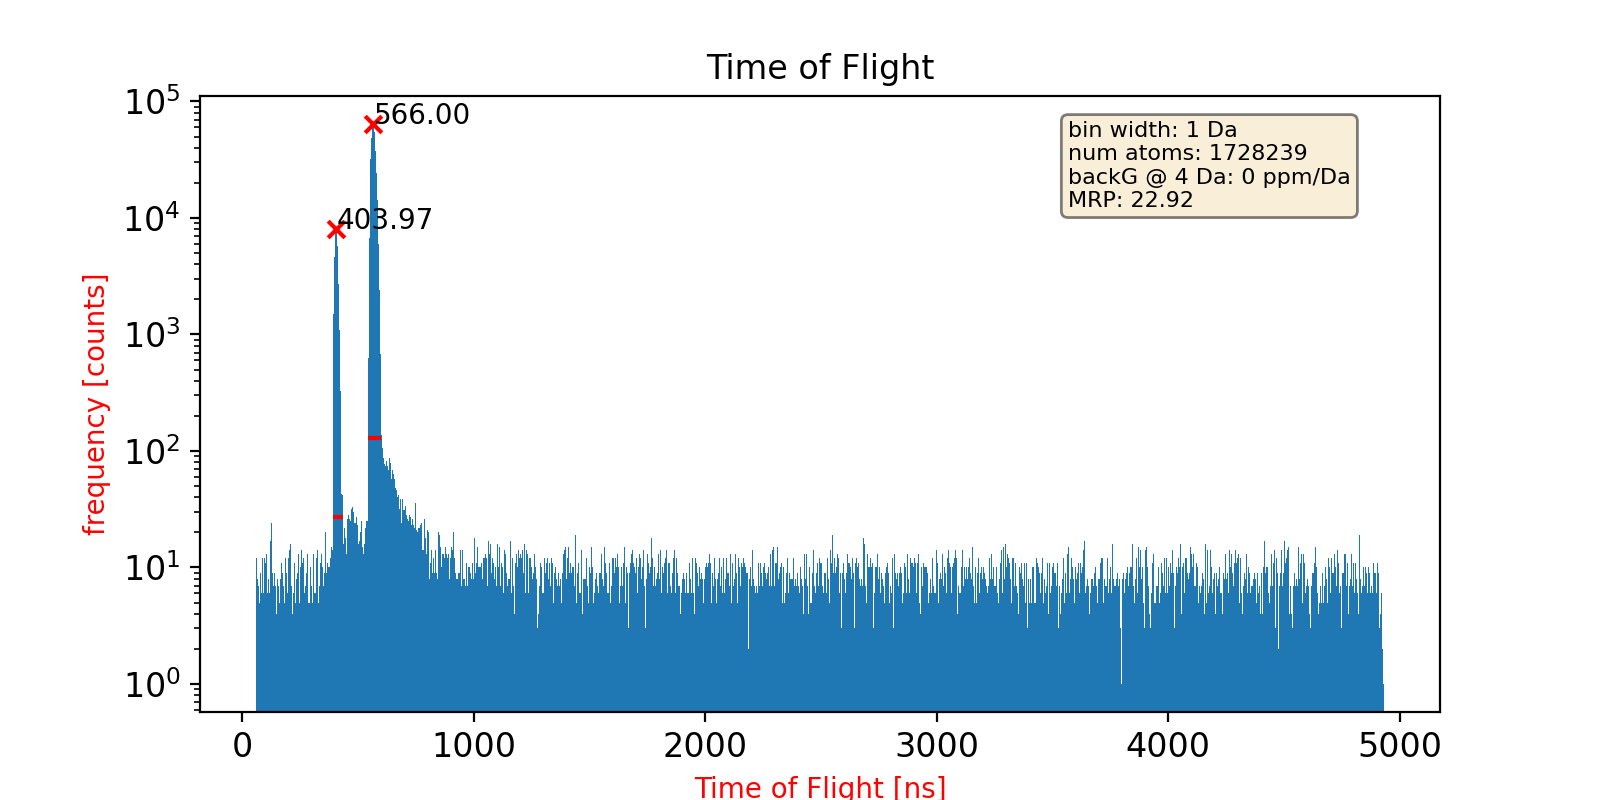

In [6]:
max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t[dld_t < 5000], 1, distance=100, percent=50, prominence=100, plot=True, label='tof')

$\text{Plot the m/c. It is possible to modify the peak selection algorithm by seting different value for prominance and distance variable in massSpecPlot function.}$

<IPython.core.display.Javascript object>


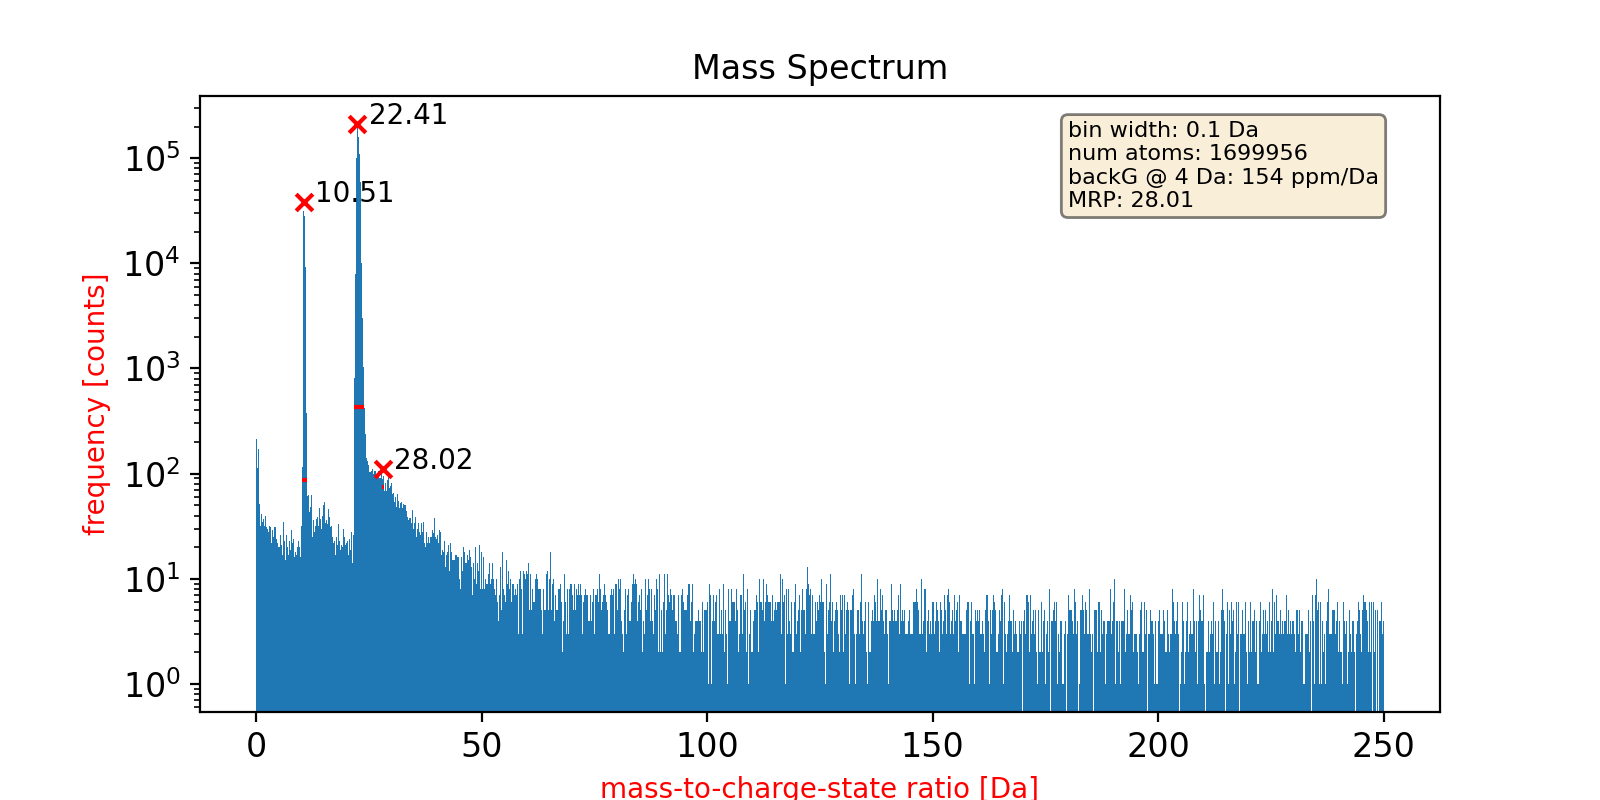

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [28.00719297]
Peaks  0 is: 10.51 peak window sides are: 10.31 - 10.71
Peaks  1 is: 22.41 peak window sides are: 22.11 - 22.91
Peaks  2 is: 28.02 peak window sides are: 21.51 - 30.22


In [7]:
mc_seb = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 250], 0.1, peaks_find=True, percent=50, prominence=30, distance=50, plot=True, text_loc='right', fig_name=figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

$\text{Details of selected peaks is displayed below:}$

In [8]:
print('################ Before starting the colibration ################')
print('Maximum pick value:', max_hist, 'right-left side of the peak:', left_right_peaks)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))
print('#################################################################')

################ Before starting the colibration ################
Maximum pick value: [22.41415529] right-left side of the peak: [22.11404281 22.91434277]
Mass resolving power (MRP --> m/m_2-m_1): [28.00719297]
Peaks  0 is: 10.51 peak window sides are: 10.31 - 10.71
Peaks  1 is: 22.41 peak window sides are: 22.11 - 22.91
Peaks  2 is: 28.02 peak window sides are: 21.51 - 30.22
#################################################################


$\text{User can tune/specify parameters below as per their requirements}$

In [9]:
mc_temp = mc_seb
mean_t = 0.001  # 0.3 the threshold by user instead of total mean
mrp_final = 0
iteration = 0
break_i = 0
ionsPerFitSegment = int(len(dld_t) / 70) # choose by dividing the dataset to 70 segments
print('Ions fit per segment is:',  ionsPerFitSegment)

Ions fit per segment is: 24689


$\text{Computation voltage and bowl correction based on the user-provided parameters. The loop breaks if there is no improvment in MRP for 3 itrations}$

(array([28], dtype=int64),)



<IPython.core.display.Javascript object>


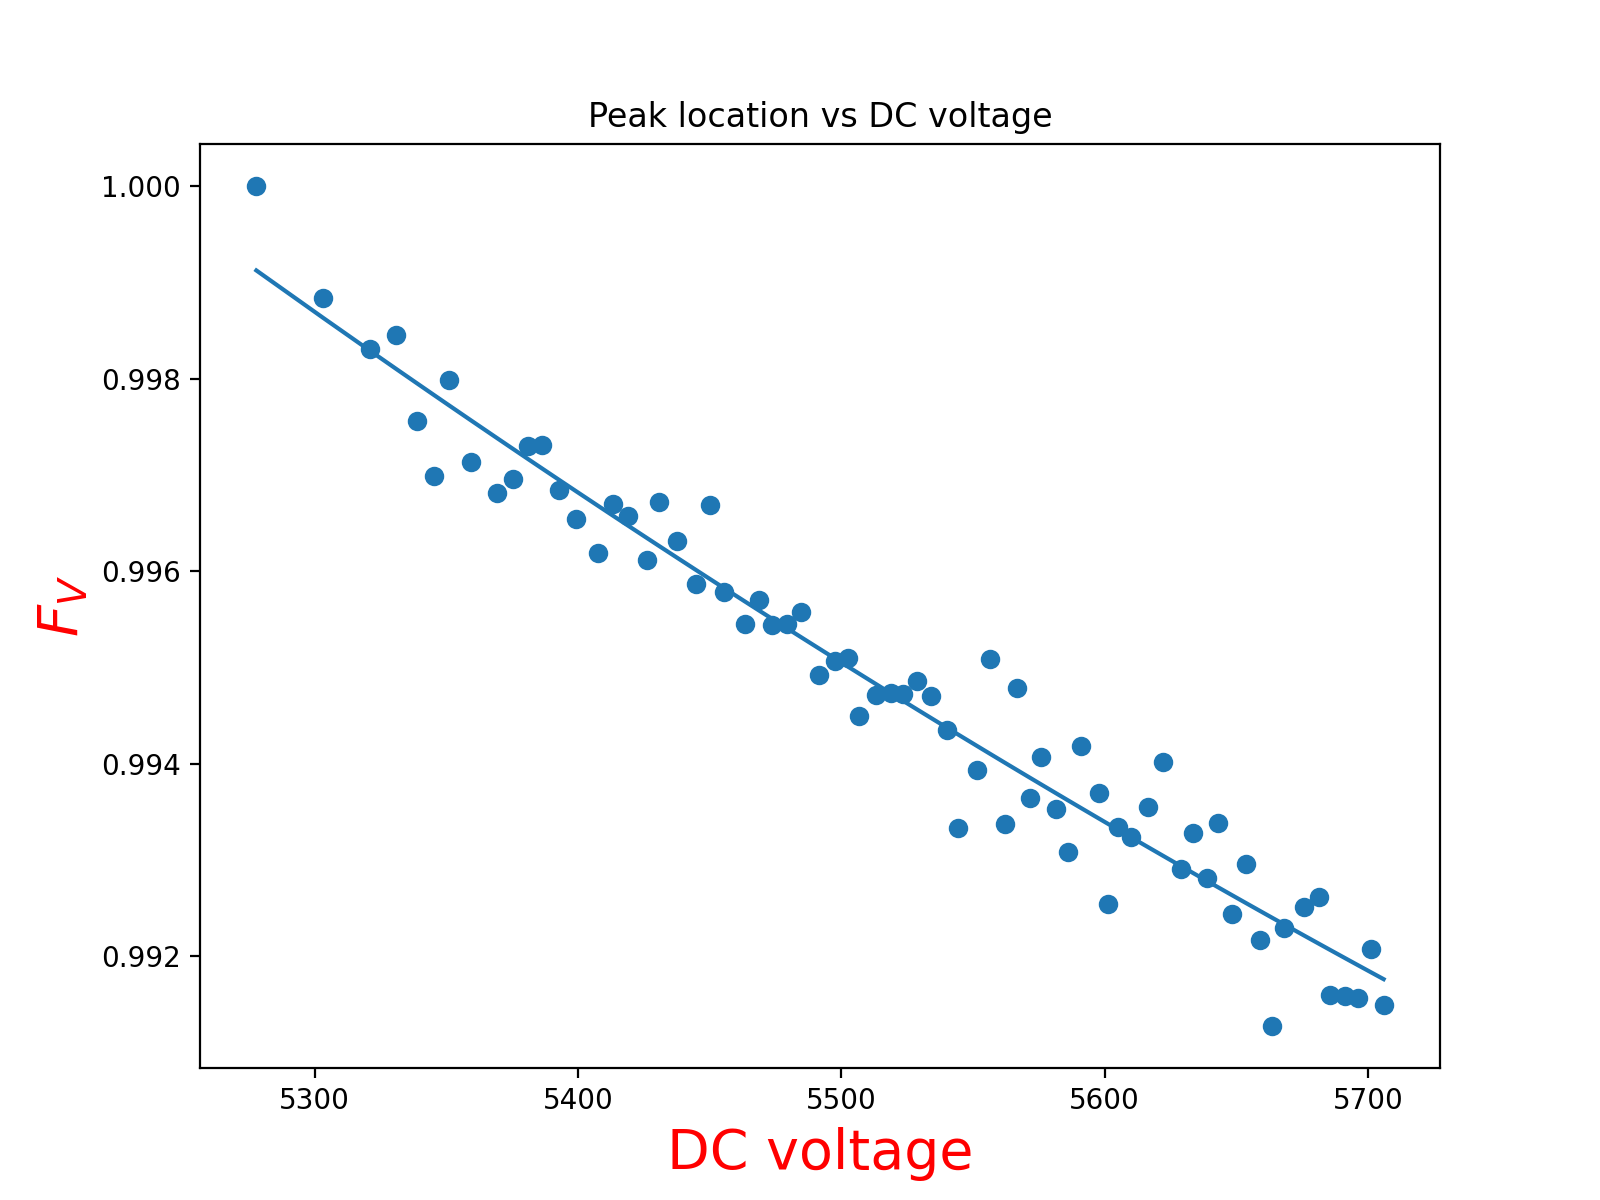

<IPython.core.display.Javascript object>


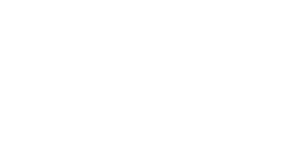

Iteration: 0 Voltage correction
Peaks in the 2D histogram [array([0.]), array([14.0625])]
Maximum pick value: [22.52521708] right-left side of the peak: [22.22495774 23.02564931]
Mass resolving power (MRP --> m/m_2-m_1): [28.13220241]


<IPython.core.display.Javascript object>


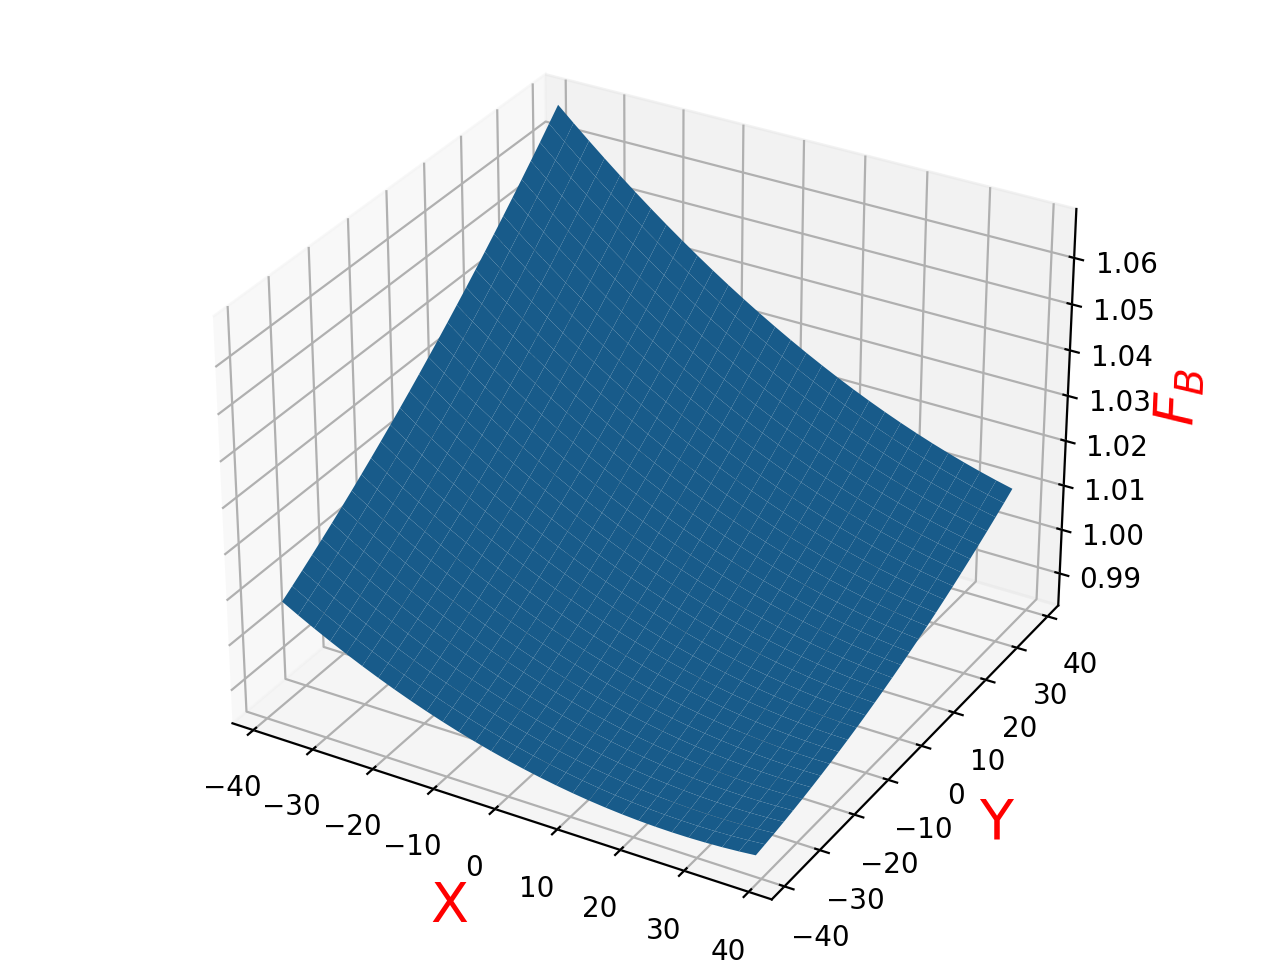

<IPython.core.display.Javascript object>


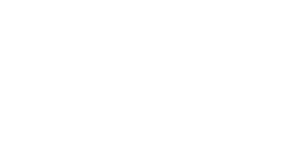

Iteration: 0 Bowl correction
Peaks in the 2D histogram [array([0.]), array([14.0625])]
Maximum pick value: [22.42544235] right-left side of the peak: [22.32535371 22.52553099]
Mass resolving power (MRP --> m/m_2-m_1): [28.13220241]
(array([28], dtype=int64),)



<IPython.core.display.Javascript object>


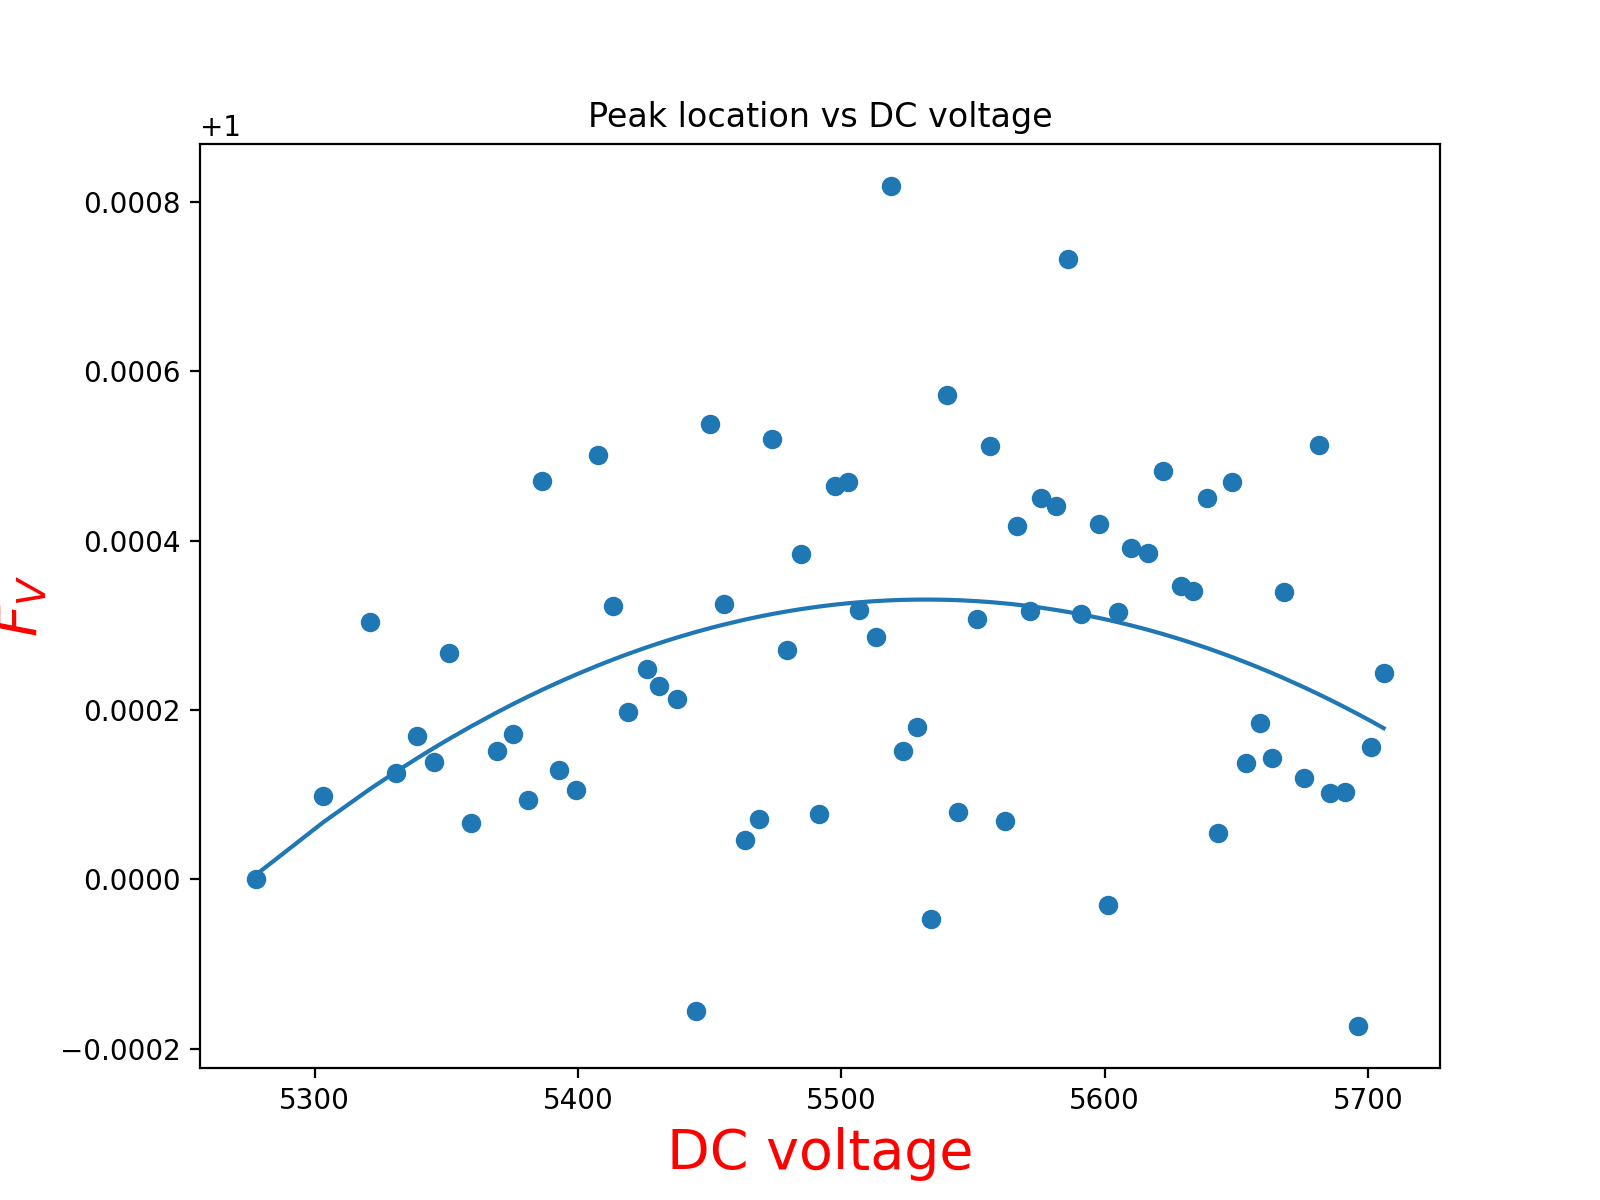

<IPython.core.display.Javascript object>


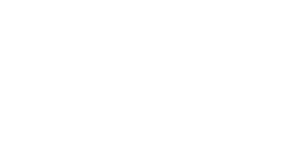

Iteration: 1 Voltage correction
Peaks in the 2D histogram [array([0.]), array([12.3046875])]
Maximum pick value: [22.41812763] right-left side of the peak: [22.31807164 22.51818361]
Mass resolving power (MRP --> m/m_2-m_1): [112.0279163]


<IPython.core.display.Javascript object>


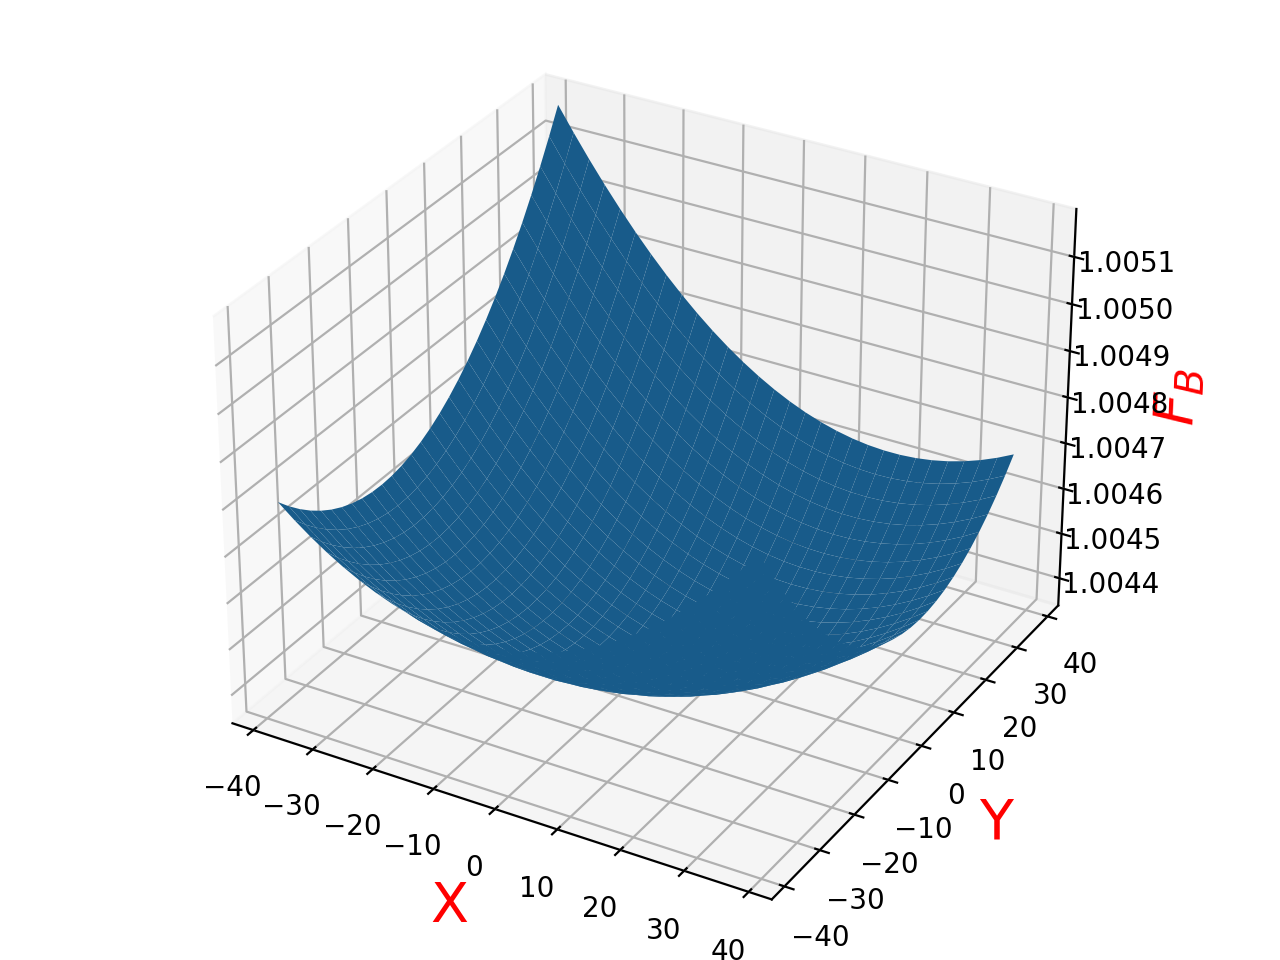

<IPython.core.display.Javascript object>


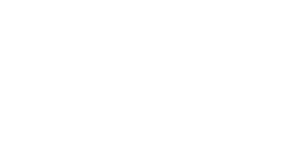

Iteration: 1 Bowl correction
Peaks in the 2D histogram [array([0.]), array([12.3046875])]
Maximum pick value: [22.32354159] right-left side of the peak: [22.12338033 22.42362222]
Mass resolving power (MRP --> m/m_2-m_1): [112.0279163]
(array([28], dtype=int64),)



<IPython.core.display.Javascript object>


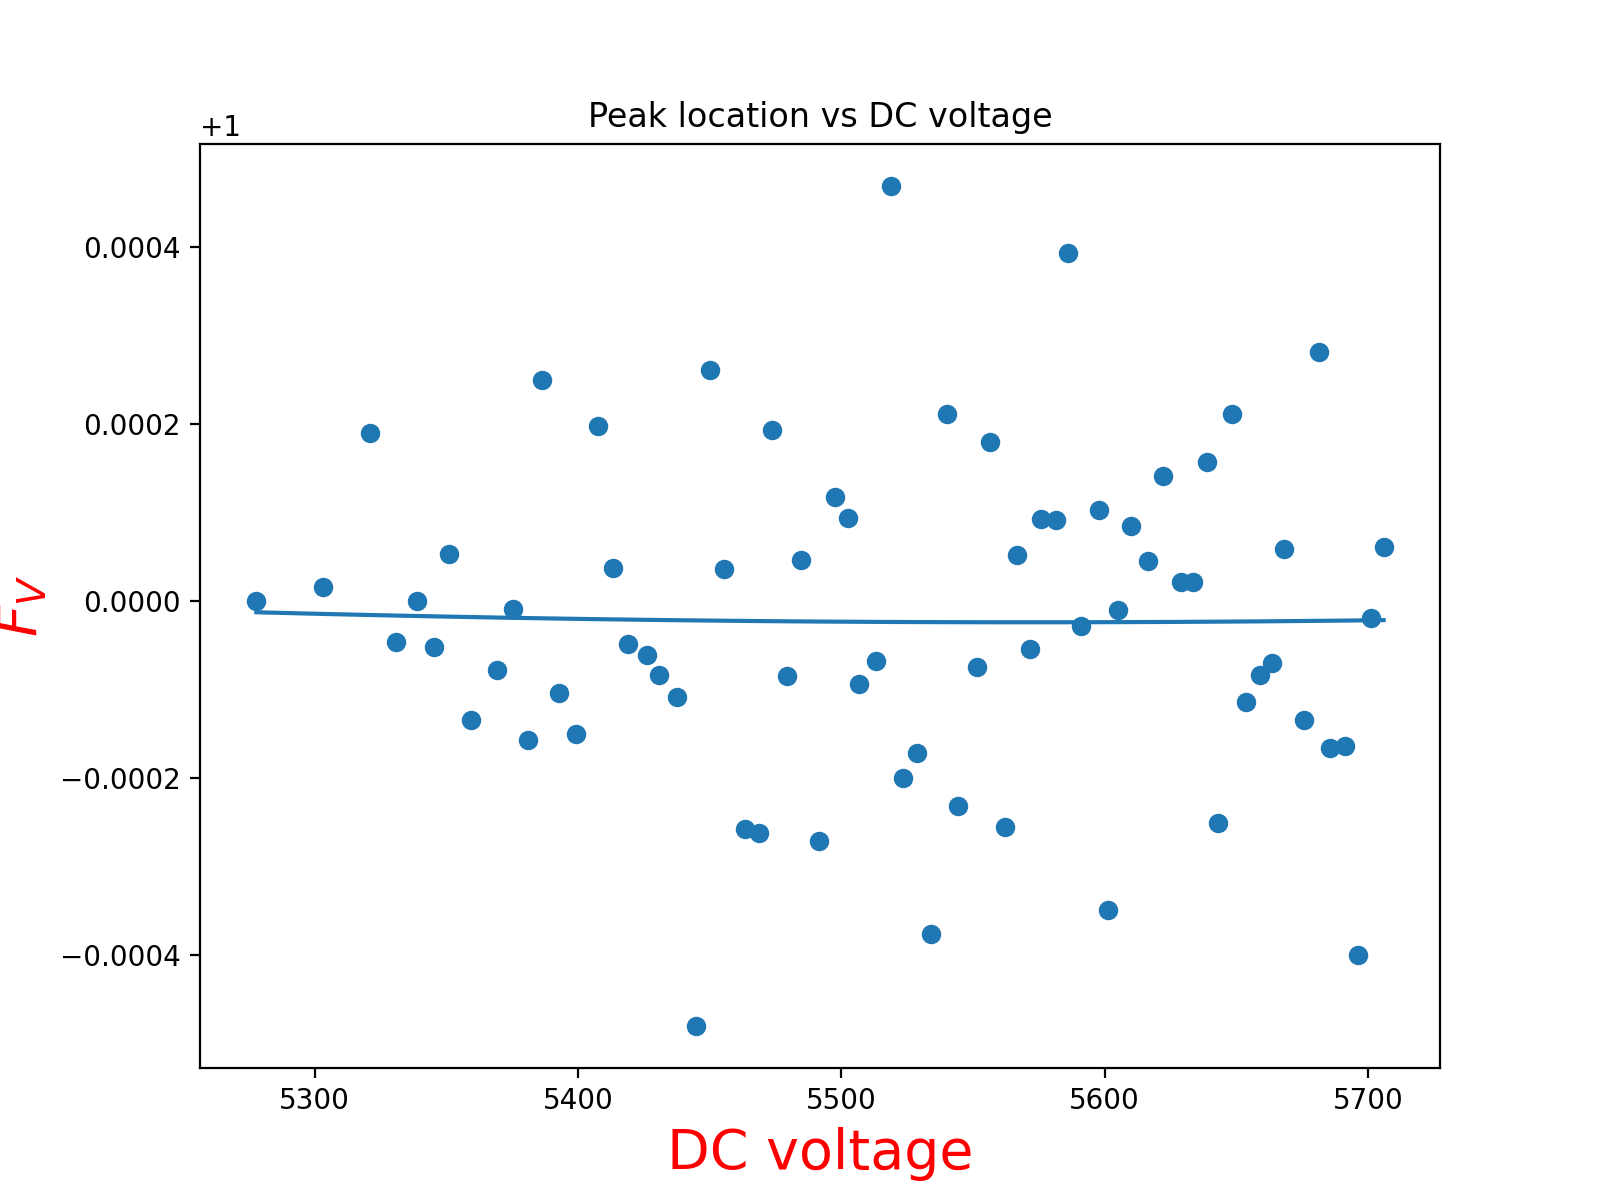

<IPython.core.display.Javascript object>


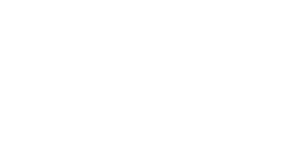

Iteration: 2 Voltage correction
Peaks in the 2D histogram [array([0.]), array([13.0859375])]
Maximum pick value: [22.32398921] right-left side of the peak: [22.12382393 22.42407185]
Mass resolving power (MRP --> m/m_2-m_1): [74.35185446]


<IPython.core.display.Javascript object>


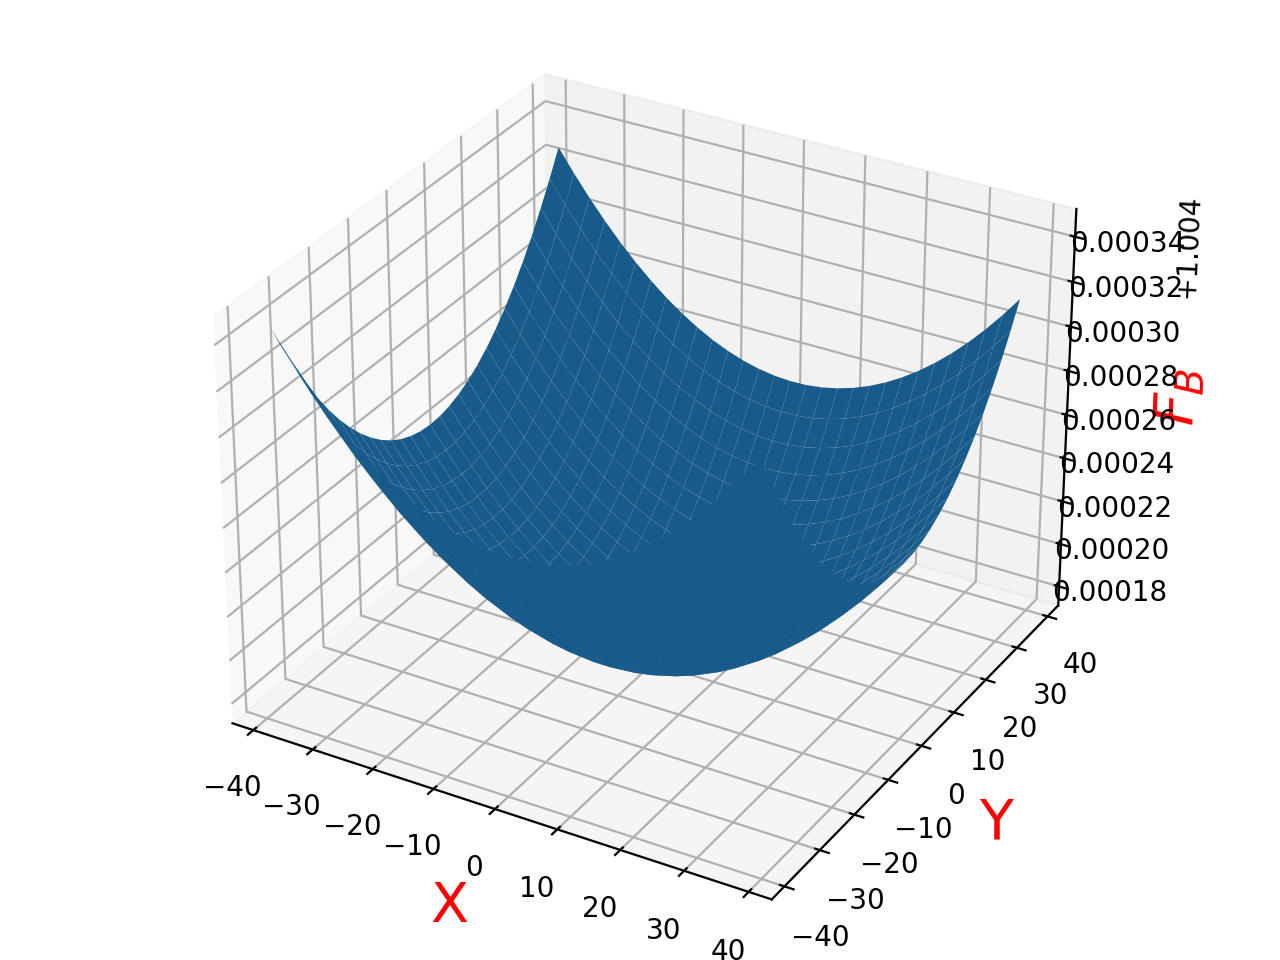

<IPython.core.display.Javascript object>


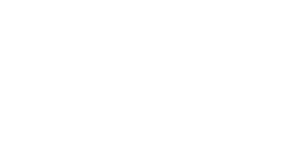

Iteration: 2 Bowl correction
Peaks in the 2D histogram [array([0.]), array([13.0859375])]
Maximum pick value: [22.22545641] right-left side of the peak: [22.12536669 22.32554614]
Mass resolving power (MRP --> m/m_2-m_1): [74.35185446]
(array([28], dtype=int64),)



<IPython.core.display.Javascript object>


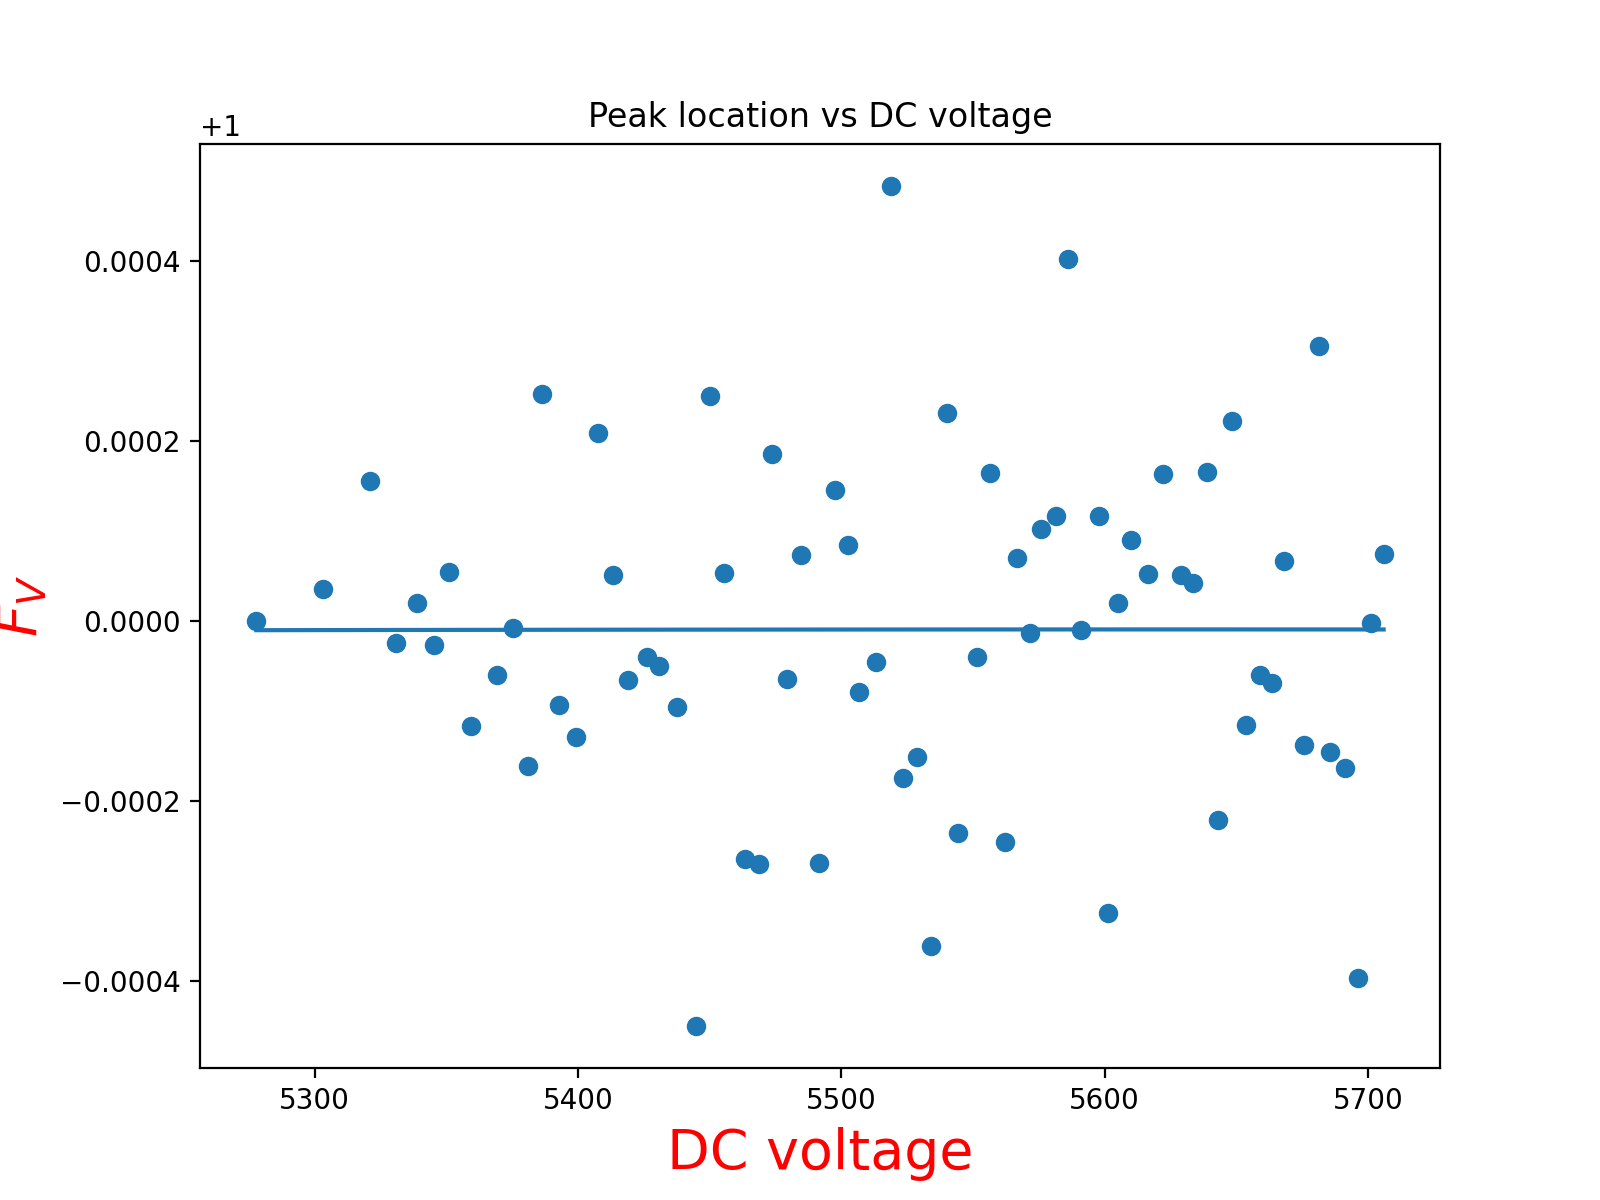

<IPython.core.display.Javascript object>


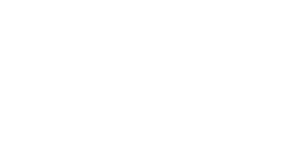

Iteration: 3 Voltage correction
Peaks in the 2D histogram [array([0.]), array([12.109375])]
Maximum pick value: [22.22567478] right-left side of the peak: [22.12558407 22.32576549]
Mass resolving power (MRP --> m/m_2-m_1): [111.02766322]


<IPython.core.display.Javascript object>


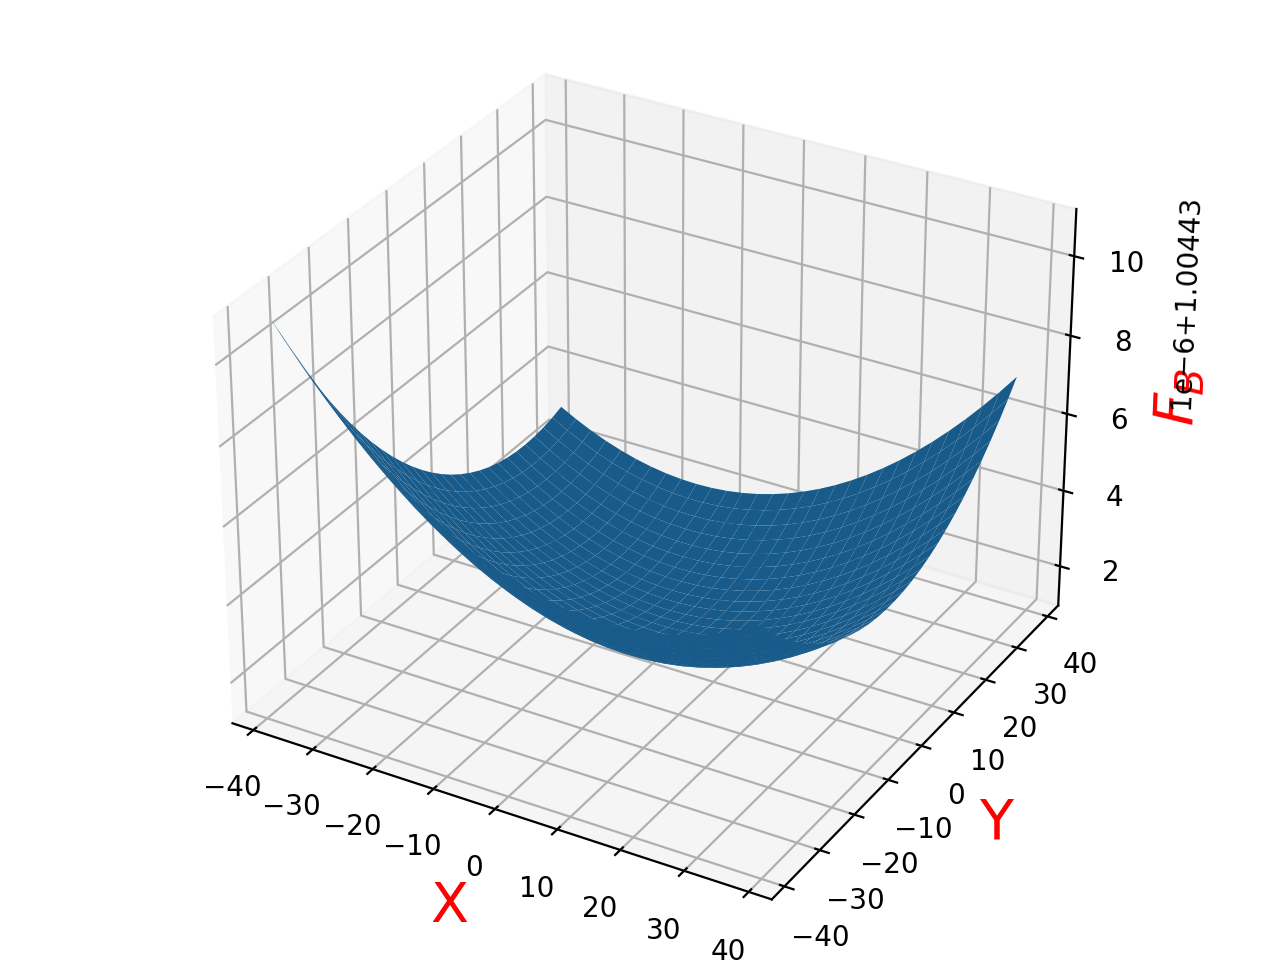

<IPython.core.display.Javascript object>


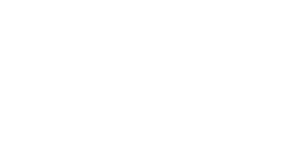

Iteration: 3 Bowl correction
Peaks in the 2D histogram [array([0.]), array([12.109375])]
Maximum pick value: [22.1218776] right-left side of the peak: [22.02180355 22.22195165]
Mass resolving power (MRP --> m/m_2-m_1): [111.02766322]


In [10]:
while True:
    fitPeak = tools.history_ex(mc_temp, dld_highVoltage, mean_t,mc_max=400, plot=False)
    corrFac_voltage = tools.voltage_corr(dld_highVoltage, mc_temp, fitPeak, ionsPerFitSegment, plot=True, fig_name='%s_'%break_i + figname)
    mc_temp2 = mc_temp / corrFac_voltage
    max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_temp2[mc_temp2 < 100], 0.1, plot=False)
    mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
    if mrp_final < mrp and break_i != 0:
        mrp_final = mrp
        mc_f = mc_temp2
    print('Iteration:', iteration, 'Voltage correction')
    print('Peaks in the 2D histogram', fitPeak)
    print('Maximum pick value:',max_hist , 'right-left side of the peak:', left_right_peaks)
    print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
    corrFac_bowl = tools.bowl_corr(dld_x, dld_y, mc_temp2, mcIdeal=max_hist, mc_min=max_paek_edges[0], mc_max=max_paek_edges[1], plot=True, fig_name='%s_'%break_i + figname)
    mc_temp3 = mc_temp2 / corrFac_bowl
    max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_temp3[mc_temp3 < 100], 0.1, plot=False)
    mc_temp = mc_temp3
    
    print('Iteration:', iteration, 'Bowl correction')
    print('Peaks in the 2D histogram', fitPeak)
    print('Maximum pick value:',max_hist , 'right-left side of the peak:', left_right_peaks)
    print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
    if mrp_final < mrp and break_i != 0:
        mrp_final = mrp
        mc_f = mc_temp
    else:
        if break_i == 3:
            break
        break_i += 1

    iteration += 1


$\text{Peak the peaks that you want to use for linear correcction by slecting the red cross on top of the peak}$

In [ ]:
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_f[mc_f < 100], 0.1, plot=True, prominence=100, fig_name='cor_'+figname, text_loc='right')

In [ ]:
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]))

$\text{Here we should choose the m/c for the selected above peak}$

In [6]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList,elementIsotopeList,elementMassList,abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0],element[1],element[3]),element[2],)
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown)
display(chargeDropdown)
display(buttonAdd)
display(buttonDelete)
display(buttonReset)
listMaterial = buttonAdd.on_click(wd.onClickAdd)
buttonDelete.on_click(wd.onClickDelete)
buttonReset.on_click(wd.onClickReset)

Dropdown(description='Elements', options=(('H (1) (99.98)', 1.01), ('H (2) (0.01)', 2.01), ('He (3) (0.00)', 3…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

In [1]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(peaks_sides[variables.peaks_idx[i],0])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(listMaterial)
print('highest peak in the mc histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', variables.listMaterial)

NameError: name 'variables' is not defined

$\text{Above you should see the selected peak values and the ideal m/c for them seperatly. By runing the below cell linear correction aplies on the m/c and the final result is plotted}$

In [ ]:
# For quadratic you need at least 3 points
mc_final = tools.linear_correction(mc_f, peaks_chos, np.array(variables.listMaterial), kind='linear')

In [ ]:
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, plot=True)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max  = tools.massSpecPlot(mc_f[mc_f < 100], 0.1, plot=True, prominence=800, fig_name=None, text_loc='right')
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max  = tools.massSpecPlot(mc_final[mc_final < 100], 0.1, plot=True, prominence=800, fig_name='linear_cor_'+figname, text_loc='right')
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)